# NEXUS tool: case study for the Souss-Massa basin - energy demand and energy supply options calculations
In this notebook a case study for the Souss-Massa basin is covered using the `nexus_tool` package. The water requirements for agricultural irrigation, residential, industrial and tourism use were previously calculated using the Water Evaluation and Planning System (WEAP) model. In this case study, the energy requirements for groundwater pumping, wastewater treatment, desalination of seawater and pumping for water conveyance are estimated. Furthermore, least-cost energy supply options for agricultular water pumping are evaluated, making use of a Least Cost of Electricity (LCOE) methodology.

First import the package by running the following block:

In [1]:
%load_ext autoreload

In [2]:
%autoreload
import sys
sys.path.append("..") #this is to add the avobe folder to the package directory
import os
import nexus_tool
from nexus_tool.weap_tools import create_folder
from nexus_tool.weap_tools import create_learning_curve
# import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# from pandas.plotting import register_matplotlib_converters
import plotly.express as px
# register_matplotlib_converters()

## Energy demand calculations

In [19]:
# Posible scenarios in this case study: 'Reference', 'Desalination' and 'Irrigation intensification'
scenario = 'Reference Wastewater Reuse'
climate = 'Trend'

load_folder = os.path.join('Data', 'Processed results')
results_folder = "test results"

save_results = 'n' # y/n

scenario_folder = os.path.join(load_folder, scenario)
sub_scenario_folder = os.path.join(scenario_folder, climate)

load_data = sub_scenario_folder
#Define the path to read the scenario input data and reads it in
file_path = os.path.join(load_data, 'demand_data.gz')
df = nexus_tool.read_csv(file_path)

#Creates the nexus model with the input dataframe
souss_massa = nexus_tool.Model(df)

#Define the diameter of the pipelines. The first is general for all and the following specific for each case
souss_massa.df['Pipe_diameter'] = 0.4
souss_massa.df.loc[souss_massa.df['type'].str.contains('GW'), 'Pipe_diameter'] = 1
souss_massa.df.loc[souss_massa.df['type'].str.contains('Pipeline'), 'Pipe_diameter'] = 1.2
souss_massa.df.loc[souss_massa.df['type'].str.contains('DS'), 'Pipe_diameter'] = 1

#Define the variable to take into account for elevation difference and lenght of pipelines
souss_massa.elevation = 'elevation_diff' #for the case of GW, the elevation_diff is set to be the wtd
souss_massa.L = 'distance' #for the case of GW, the distance is set to be the wtd

#Defines the name of the variable for Peak Water Demand and Seasonal Water demand (monthly)
souss_massa.pwd = 'pwd'
souss_massa.sswd = 'sswd'
souss_massa.df.rename(columns={'value': 'sswd'}, inplace=True)
souss_massa.peak_Q = souss_massa.pwd #This is a work around so we are able to calculat all energy demand with the SW_pumping method
souss_massa.avg_Q = souss_massa.sswd #This is a work around so we are able to calculat all energy demand with the SW_pumping method
souss_massa.swpp_e = 'swpp_e'
souss_massa.pd_e = 'swpp_e'
souss_massa.swpa_e = 'swpa_e'
souss_massa.pumping_hours_per_day = 10
souss_massa.SWpump_eff = 0.6

#Defines the PWD. It is defined as double the seasonal demand for agricultural sites
souss_massa.df[souss_massa.pwd] = souss_massa.df[souss_massa.sswd] / 3600 / 30 / souss_massa.pumping_hours_per_day #to convert to cubic meter per second [m3/s]
souss_massa.df.loc[souss_massa.df['type']=='Agriculture', souss_massa.pwd] *= 2

#Calculates some required parameters
souss_massa.get_A(inplace=True)
souss_massa.get_V(inplace=True, axis=0)
souss_massa.get_Re(inplace=True, axis=0)
souss_massa.get_f(inplace=True, axis=0)

souss_massa.get_sw_tdh(inplace = True, axis=0) #this is called sw but it calculets for gw too. I still need to change the names
souss_massa.get_SWpumping_energy(inplace = True, axis=0) #the same here

souss_massa.df.loc[souss_massa.df.swpp_e<0, souss_massa.swpp_e] = 0
souss_massa.df.loc[souss_massa.df.swpa_e<0, souss_massa.swpa_e] = 0

#Define energy intensity for seawater desalination project
desalination_energy_int = 3.31 # kWh/m3
#We compute the energy demand for deslination multiplying the monthly water requirement by the energy intensity, 
#and add it to the current energy requirements for desalinated water pumping
sm_desal = nexus_tool.Model(souss_massa.df.loc[souss_massa.df['type'].str.contains('DS')].copy())

sm_desal.df[souss_massa.swpa_e] = sm_desal.df[souss_massa.sswd] * desalination_energy_int
#Then we divide the total energy requiered for desalination by the daily pumping hours and the days of the month
sm_desal.df[souss_massa.swpp_e] = desalination_energy_int

#Here we load the WWTP inflow data
file_path = os.path.join(load_data, 'wwtp_inflow.gz')
df_wwtp = pd.read_csv(file_path)

#We define an energy intensity for wastewater treatment and compute the energy demand
wwtp_energy_int = 0.6 # kWh/m3
df_wwtp['swpa_e'] = df_wwtp.value * wwtp_energy_int

if save_results == 'y':
    create_folder(results_folder)
    create_folder(os.path.join(results_folder, scenario))
    create_folder(os.path.join(results_folder, scenario, climate))
    output_main_folder = os.path.join(results_folder, scenario, climate)
    souss_massa.df.to_csv(os.path.join(output_main_folder, 'results.gz'), index=False)
    sm_desal.df.to_csv(os.path.join(output_main_folder, 'desal_data.gz'), index=False)
    df_wwtp.to_csv(os.path.join(output_main_folder, 'wwtp_data.gz'), index=False)

## Explore some results

In [20]:
df = souss_massa.df

In [34]:
def water_delivered_plot(data, water_delivered, time_frame):
    name = 'Water delivered (Mm3)'
    dff_delivered = water_delivered.copy()
    dff_delivered.loc[dff_delivered['type'].str.contains('Agriculture'), 'category'] = 'Agriculture'
    dff_delivered.loc[dff_delivered['type'].str.contains('Domestic'), 'category'] = 'Domestic'
    dff_delivered.loc[dff_delivered['type'].str.contains('Aquifer'), 'category'] = 'Aquifer recharge'
    dff_delivered.loc[dff_delivered['type'].str.contains('SW|Aquifer'), 'type'] = 'Surface water'
    dff_delivered.loc[dff_delivered['type'].str.contains('GW'), 'type'] = 'Groundwater'
    dff_delivered.loc[dff_delivered['type'].str.contains('DS'), 'type'] = 'Desalinated water'
    dff_delivered.loc[dff_delivered['type'].str.contains('WWR'), 'type'] = 'Wastewater reuse'
    dff_delivered = dff_delivered.loc[dff_delivered['type'] != 'Transmission Pipeline']
    dff_delivered = dff_delivered.groupby([time_frame, 'category', 'type'])['sswd'].sum() / 1000000
    dff_delivered = dff_delivered.reset_index()

    dff_delivered_cat = dff_delivered.groupby([time_frame, 'category']).sswd.sum()
    dff_delivered['share'] = dff_delivered.sswd / dff_delivered.set_index([time_frame, 'category']).index.map(dff_delivered_cat)

    df = dff_delivered_cat.reset_index()
    data[name] = [{'x': df.loc[df['category'] == category, time_frame],
                   'y': df.loc[df['category'] == category].sswd,
                   'name': category,
                   'stackgroup': 'one',
                   'mode': 'lines',
                   'text': ["<br>".join([f'{row[1]["type"]}: {round(row[1]["share"]*100,2)}%' for row in group.iterrows()]) \
                            for year, group in dff_delivered.loc[dff_delivered['category'] == category].groupby(time_frame)],
                   'hovertemplate': '<b>Value</b>: %{y:.2f}' + '<br><b>Date</b>: %{x}' +
                                    '<br><b>Supply</b>: %{text}'
                   } for category in sorted(df['category'].unique())]
    return data

In [35]:
def unmet_demand_plot(data, water_delivered, time_frame):
    name = 'Unmet water demand (%)'
    dff_unmet = water_delivered.copy()
    dff_unmet.loc[dff_unmet['type'].str.contains('Agriculture'), 'category'] = 'Agriculture'
    dff_unmet.loc[dff_unmet['type'].str.contains('Domestic'), 'category'] = 'Domestic'
    dff_unmet = dff_unmet.loc[~dff_unmet['type'].str.contains('Aquifer')]
    dff_unmet = dff_unmet.loc[dff_unmet['type'] != 'Transmission Pipeline']
    water_req_year = dff_unmet.groupby(['Year', 'Date', 'Demand point', 'category'])['water_required'].mean().reset_index().groupby(
        [time_frame, 'category'])['water_required'].sum()
    unment_demand = 1 - (dff_unmet.groupby([time_frame, 'category'])['sswd'].sum() /
                         water_req_year)

    df = unment_demand.reset_index()
    data[name] = [{'x': df.loc[df['category'] == category, time_frame],
                   'y': df.loc[df['category'] == category].iloc[:,2],
                   'name': category,
                   'mode': 'lines',
                   'hovertemplate': '<b>Value</b>: %{y:,.2%}' + '<br><b>Date</b>: %{x}'
                   } for category in sorted(df['category'].unique())]
    return data

In [36]:
def energy_demand_plot(data, water_delivered, wwtp_data, desal_data, time_frame):
    emission_factor = 1.76
    dff_energy = water_delivered.copy()
    dff_energy.loc[dff_energy['type'].str.contains('GW'), 'type'] = 'Groundwater pumping'
    dff_energy.loc[dff_energy['type'].str.contains('SW|Pipeline'), 'type'] = 'Surface water conveyance'
    dff_energy.loc[dff_energy['type'].str.contains('DS'), 'type'] = 'Desalinated water conveyance'
    dff_energy.loc[dff_energy['type'].str.contains('WWR'), 'type'] = 'Wastewater reuse conveyance'
    dff_energy = dff_energy.groupby([time_frame, 'type'])['swpa_e'].sum() / 1000000
    dff_energy = dff_energy.reset_index()
    wwtp_data['type'] = 'Wastewater treatment'
    desal_data['type'] = 'Desalination energy'
    for df in [wwtp_data, desal_data]:
        dff = df.groupby([time_frame, 'type'])['swpa_e'].sum() / 1000000
        dff = dff.reset_index()
        dff_energy = dff_energy.append(dff, sort=False)

    name = 'Energy demand (GWh)'
    df = dff_energy
    data[name] = [{'x': df.loc[df['type'] == type, time_frame],
                   'y': df.loc[df['type'] == type].swpa_e,
                   'name': type,
                   'stackgroup': 'one',
                   'mode': 'lines',
                   'text': df.loc[df['type'] == type].swpa_e * emission_factor / 1000,
                   'hovertemplate': '<b>Value</b>: %{y:.2f}' + '<br><b>Date</b>: %{x}'
                                    # '<br><b>Emissions</b>: %{text: 0.2f} MtCO2'
                   } for type in sorted(df['type'].unique())]
    return data

In [37]:
def water_supply_plot(data, water_delivered, time_frame):
    name = 'Water supplied (Mm3)'
    dff_delivered = water_delivered.copy()
    dff_delivered.loc[dff_delivered['type'].str.contains('SW|Aquifer'), 'type'] = 'Surface water'
    dff_delivered.loc[dff_delivered['type'].str.contains('GW'), 'type'] = 'Groundwater'
    dff_delivered.loc[dff_delivered['type'].str.contains('DS'), 'type'] = 'Desalinated water'
    dff_delivered.loc[dff_delivered['type'].str.contains('WWR'), 'type'] = 'Reused Wastewater'
    dff_delivered = dff_delivered.loc[dff_delivered['type'] != 'Transmission Pipeline']
    dff_delivered = dff_delivered.groupby([time_frame, 'type'])['sswd'].sum() / 1000000
    dff_delivered = dff_delivered.reset_index()

    df = dff_delivered.reset_index()
    data[name] = [{'x': df.loc[df['type'] == type, time_frame],
                   'y': df.loc[df['type'] == type].sswd,
                   'name': type,
                   'stackgroup': 'one',
                   'mode': 'lines',
                   'hovertemplate': '<b>Value</b>: %{y:.2f}' + '<br><b>Date</b>: %{x}'
                   } for type in sorted(df['type'].unique())]
    return data

In [40]:
import plotly.graph_objects as go

data = {}
data = water_delivered_plot(data, df, 'Year')
fig = go.Figure(data=data['Water delivered (Mm3)'])
fig.layout['title'] = dict(text='Water delivered (Mm3)')
fig.layout['barmode'] = 'stack'
fig.show()

In [42]:
data = {}
data = unmet_demand_plot(data, df, 'Date')
fig = go.Figure(data=data['Unmet water demand (%)'])
fig.layout['title'] = dict(text='Unmet water demand (%)')
fig.layout['yaxis'] = {'tickformat': ',.0%', 'range': [0, 1]}
fig.show()

In [45]:
data = {}
data = water_supply_plot(data, df, 'Year')
fig = go.Figure(data=data['Water supplied (Mm3)'])
fig.layout['title'] = dict(text='Water supplied (Mm3)')
fig.layout['barmode'] = 'stack'
fig.show()

In [48]:
data = {}
data = energy_demand_plot(data, df, df_wwtp, sm_desal.df, 'Year')
fig = go.Figure(data=data['Energy demand (GWh)'])
fig.layout['title'] = dict(text='Energy demand (GWh)')
fig.layout['barmode'] = 'stack'
fig.show()

## Standalone energy supply options (LCOE method) in agricultural areas

In [84]:
w_rate = 0 #suggested wind CAPEX reductions for this case study: 0, 0.3, 0.5 and 0.7
pv_rate = 0.5 #suggested PV CAPEX reductions for this case study: 0, 0.3, 0.5 and 0.7
grid_rate = -0.3 #suggested Grid price increment for this case study: 0, -0.3, -0.5 and -0.7 (the - symbol represents a negative reduction rate=increment)

save_results = 'n' # y/n

#Define the path to read the cropland and builtup are data and reads it in
folder_path = os.path.join('Data', 'Cropland and Builtarea')
cropland_path = os.path.join(folder_path, 'cropland.gz')
cropland = nexus_tool.read_csv(cropland_path)
cropland = cropland.loc[cropland.Date.isin(souss_massa.df.Date.unique())]

summary_provinces_agri = souss_massa.df.loc[souss_massa.df['type'].str.contains('Agriculture')].groupby(['Province', 'Date'])[['sswd', 'pwd', 'swpa_e', 'swpp_e']].sum()
temp_cropland_provinces = cropland[['province', 'Date']].copy()
temp_cropland_provinces.loc[temp_cropland_provinces['province']=='Inezgane-Aït Melloul', 'province'] = 'Taroudannt'

for feature in list(summary_provinces_agri):
    cropland[feature] = temp_cropland_provinces.set_index(['province', 'Date']).index.map(summary_provinces_agri[feature]) * cropland['area_share']

sm_cropland = nexus_tool.Model(cropland)

sm_cropland.start_year = 2020
sm_cropland.end_year = 2050
sm_cropland.discount_rate = 0.05
sm_cropland.pwd = 'pwd'
sm_cropland.sswd = 'sswd'
sm_cropland.pd_e = 'swpp_e'
sm_cropland.swpp_e = 'swpp_e'
sm_cropland.swpa_e = 'swpa_e'

cc = 1250
rates = {2020: 0, 2030: w_rate*0.3, 2040: w_rate, 2050: w_rate*1.3}
cc_wind_curve = create_learning_curve(sm_cropland.start_year, sm_cropland.end_year, cc, rates, 'polynomial')

sm_cropland.create_wind_turbine('Wind power', life=20,
                                om_cost=0.01, capital_cost=cc_wind_curve,
                                efficiency=1)
sm_cropland.technologies['Wind power'].p_rated = 80
sm_cropland.technologies['Wind power'].p_curve = [0, 0, 0, 0, 2.9, 6, 11, 17.7, 27.3, 39.2, 51.4, 63.8, 74.2, 79.9, 82.2, 82.9, 83.3, 83.3, 83, 83, 83]
sm_cropland.technologies['Wind power'].u_arr = range(0, 21)
sm_cropland.technologies['Wind power'].z = 39

cc = 1000
rates = {2020: 0, 2030: pv_rate*0.3, 2040: pv_rate, 2050: pv_rate*1.3}
cc_solar_curve = create_learning_curve(sm_cropland.start_year, sm_cropland.end_year, cc, rates, 'polynomial')

sm_cropland.create_pv_system('Solar PV', life=15,
                             om_cost=0.01, capital_cost=cc_solar_curve,
                             efficiency=1)

cc = 0.12
rates = {2020: 0, 2030: grid_rate*0.3, 2040: grid_rate, 2050: grid_rate*1.3}
e_price_curve = create_learning_curve(sm_cropland.start_year, sm_cropland.end_year, cc, rates, 'step')

sm_cropland.create_standard_tech('Grid pump', life=15, om_cost=0.1,
                                 capital_cost=0, fuel_cost=e_price_curve,
                                 fuel_req=1, efficiency=0.85, cf = 0.8,
                                 emission_factor=1.76, env_cost=0)

sm_cropland.get_cf('all', axis=0)
sm_cropland.get_installed_capacity('all', axis=0)
sm_cropland.get_max_capacity('a', axis=0)
sm_cropland.get_lcoe(years='all', axis=0)
sm_cropland.get_least_cost(technologies='a', years='all', axis=0)

if save_results == 'y':
    output_folder = os.path.join(output_main_folder, f'W{w_rate}_PV{pv_rate}_Grid{grid_rate}')
    create_folder(output_folder)
#     sm_cropland.lcoe.drop(columns=['water demand', 'required capacity', 'energy demand'], inplace=True)
    sm_cropland.lcoe.reset_index().to_csv(os.path.join(output_folder, 'lcoe.gz'), index=False)

## From here onwards you will find some code to explore the LCOE results
Variables meaning:
* `sswd`: Seasonal water demand
* `swpa_e`: Seasonal water pumping energy demand

### General summary

In [19]:
year = [2020] #input the year to summarize the results
demand_type = "" #input the energy type to summarize ('Domestic', 'Agriculture', 'recharge', 'Transmission', '')
group_by = ['Province','type'] #input the groups to aggreate the data in the desired order. e.g. ['Year', 'Demand point'], ['Province', 'Year']

df_group = souss_massa.df.loc[(souss_massa.df.Year.isin(year))&(souss_massa.df.type.str.contains(demand_type))].groupby(group_by)[['sswd','swpa_e']].sum()/1000000
df_group.rename(columns={'sswd': 'Water demand [Mm3]', 'swpa_e': 'Energy demand [GWh]'}, inplace=True)
df_group['Energy intensity [kWh/m3]'] = df_group['Energy demand [GWh]'] / df_group['Water demand [Mm3]']
df_group

Water demand [Mm3]  \
Province             type                                        
Agadir-Ida ou Tanane DS Domestic                      0.000000   
                     GW Domestic                      0.000000   
                     SW Agriculture                  11.216818   
                     SW Domestic                     69.931926   
Chtouka-Aït Baha     DS Agriculture                   0.000000   
                     GW Agriculture                  44.585513   
                     GW Domestic                      4.278443   
                     SW Agriculture                  72.737904   
                     SW Domestic                      0.181598   
Taroudannt           Aquifer recharge                 5.231645   
                     GW Agriculture                 353.731155   
                     GW Domestic                     12.875316   
                     SW Agriculture                 216.876575   
                     SW Domestic                      0.287356   
                     Transmission Pipeline           38.963306   
Tiznit               GW Agriculture                  48.015772   
                     GW Domestic                      0.000027   
                     SW Domestic                      5.153750   
                     Transmission Pipeline           63.971066   

                                            Energy demand [GWh]  \
Province             type                                         
Agadir-Ida ou Tanane DS Domestic                       0.000000   
                     GW Domestic                       0.000000   
                     SW Agriculture                    0.000000   
                     SW Domestic                       0.000000   
Chtouka-Aït Baha     DS Agriculture                    0.000000   
                     GW Agriculture                   17.399503   
                     GW Domestic                       1.651096   
                     SW Agriculture                    0.000000   
                     SW Domestic                       0.000000   
Taroudannt           Aquifer recharge                 12.163106   
                     GW Agriculture                  321.319282   
                     GW Domestic                       9.250115   
                     SW Agriculture                    0.000000   
                     SW Domestic                       0.000000   
                     Transmission Pipeline            47.988309   
Tiznit               GW Agriculture                   11.263032   
                     GW Domestic                       0.000006   
                     SW Domestic                       0.000000   
                     Transmission Pipeline            66.782926   

                                            Energy intensity [kWh/m3]  
Province             type                                              
Agadir-Ida ou Tanane DS Domestic                                  NaN  
                     GW Domestic                                  NaN  
                     SW Agriculture                          0.000000  
                     SW Domestic                             0.000000  
Chtouka-Aït Baha     DS Agriculture                               NaN  
                     GW Agriculture                          0.390250  
                     GW Domestic                             0.385911  
                     SW Agriculture                          0.000000  
                     SW Domestic                             0.000000  
Taroudannt           Aquifer recharge                        2.324910  
                     GW Agriculture                          0.908371  
                     GW Domestic                             0.718438  
                     SW Agriculture                          0.000000  
                     SW Domestic                             0.000000  
                     Transmission Pipeline                   1.231628  
Tiznit               GW A

### Energy supply options for agriculture pumping
The following block creates a summary table of the water demand, energy demand, power capacity requirements and Levelized Cost of Energy (LCOE), for the agricultural sector.

In [20]:
year = [2020,2030, 2040]
group_by = ['Year','province']
df_group = sm_cropland.lcoe.reset_index().loc[sm_cropland.lcoe.reset_index().Year.isin(year)].groupby(group_by).agg({
                                                                                                          'water demand': lambda x: sum(x) / 1000000, 
                                                                                                          'energy demand': lambda x: sum(x) / 1000000,
                                                                                                          'lcoe': 'mean',
                                                                                                          'required capacity': 'max',})
df_group.rename(columns={'water demand': 'Water demand [Mm3]', 'energy demand': 'Energy demand [GWh]',
                         'lcoe': 'LCOE [$/kWh]', 'required capacity': 'Capacity [kW]'}, inplace=True)
df_group

Water demand [Mm3]  Energy demand [GWh]  \
Year province                                                        
2020 Agadir-Ida ou Tanane           11.216818             0.000000   
     Chtouka-Aït Baha              117.323417            17.399503   
     Inezgane-Aït Melloul           38.623973            21.749841   
     Taroudannt                    531.983757           299.569442   
     Tiznit                         48.015772            11.263032   
2030 Agadir-Ida ou Tanane            9.684181             0.000000   
     Chtouka-Aït Baha              120.882334            18.642311   
     Inezgane-Aït Melloul           40.817648            25.821772   
     Taroudannt                    562.198133           355.653806   
     Tiznit                         50.585131            13.261015   
2040 Agadir-Ida ou Tanane            0.001851             0.000000   
     Chtouka-Aït Baha               57.875871            18.245167   
     Inezgane-Aït Melloul           34.924623            25.318825   
     Taroudannt                    481.031091           348.726514   
     Tiznit                         49.578974            14.365854   

                           LCOE [$/kWh]  Capacity [kW]  
Year province                                           
2020 Agadir-Ida ou Tanane           NaN       0.000000  
     Chtouka-Aït Baha          0.152945     414.794670  
     Inezgane-Aït Melloul      0.153701     913.736075  
     Taroudannt                0.153701    9512.354373  
     Tiznit                    0.154888     273.320915  
2030 Agadir-Ida ou Tanane           NaN       0.000000  
     Chtouka-Aït Baha          0.136170     418.106748  
     Inezgane-Aït Melloul      0.165929     946.337461  
     Taroudannt                0.165929    9851.747705  
     Tiznit                    0.140610     307.056693  
2040 Agadir-Ida ou Tanane           NaN       0.000000  
     Chtouka-Aït Baha          0.093384     418.946690  
     Inezgane-Aït Melloul      0.133242     735.162547  
     Taroudannt                0.129368    7653.333232  
     Tiznit                    0.095111     338.341815

### The following block creates a plot displaying a variable for each province, the variable can be `water demand`, `energy demand`, `lcoe` or `required capacity`

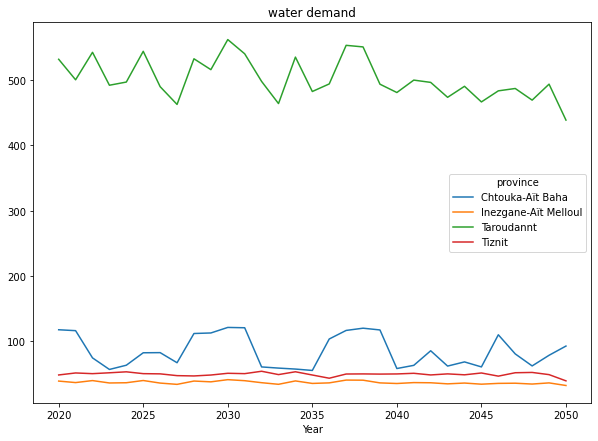

In [21]:
variable = 'water demand'
dff = sm_cropland.lcoe.reset_index().groupby(['province', 'Year']).agg({'water demand': lambda x: sum(x) / 1000000, 
                                                                        'energy demand': lambda x: sum(x) / 1000000,
                                                                        'lcoe': 'mean',
                                                                        'required capacity': 'max',}).reset_index().dropna().pivot('Year','province',variable)
amount = dff.columns.shape[0] + 1
dff.plot(figsize=(10,7),title=variable)

## GIS exploration of results
To explre geospatially the results, we will read two datasets making use of the GeoPandas package. One containing the cropland area through the Souss-Massa region and another containing the provincial administrative boundaries. 

In [181]:
 %matplotlib inline
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
# import contextily as ctx
from matplotlib import cm
import time

cropland = gpd.read_file(r"Data\GIS\Processed layers\cropland_2013_processed_20200227.csv", encoding='utf-8')
provinces = gpd.read_file('Data/GIS/Admin/Provinces.gpkg', encoding='utf-8')
provinces.to_crs('epsg:26192', inplace=True)
df = sm_cropland.lcoe.reset_index().copy()

In [183]:
cropland = cropland.loc[cropland.area_ha.astype(float)>=1]
cropland['geometry'] = cropland.geometry.simplify(0.2)

In [187]:
cropland['id'] = cropland.index
cropland.to_crs('epsg:4326').to_file(r"Data\GIS\Processed layers/cropland.geojson", driver='GeoJSON')

In [165]:
climate_title = f'Historical climate {climate}'
# climate = 'Climate Change'
# climate_title = f'Increased droughts'
df['geometry'] = df['Demand point'].map(cropland.geometry)
df.dropna(subset=['geometry'], inplace=True)
df = gpd.GeoDataFrame(df, crs='epsg:26192')
# df.to_crs('epsg:3857', inplace=True)

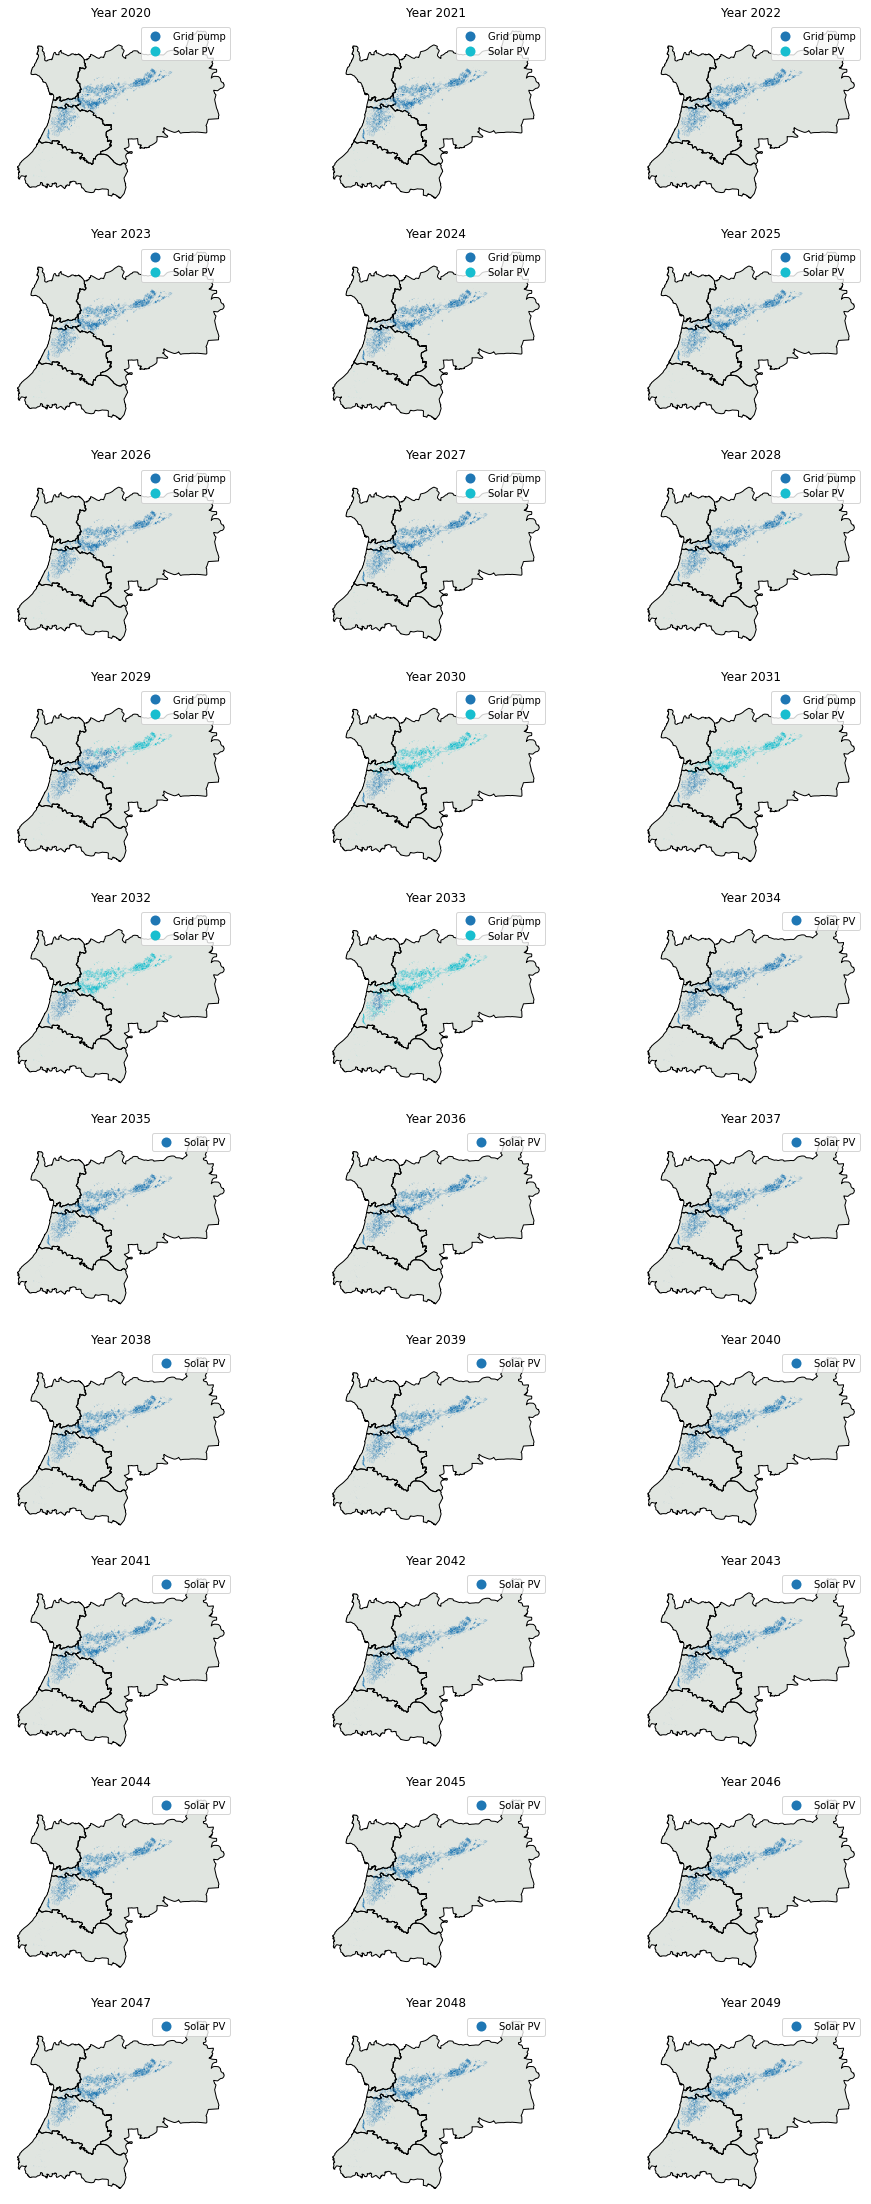

In [180]:
create_folder('maps')
# settings
nrows, ncols = 10, 3  # array of sub-plots
figsize = [16, 40]     # figure size, inches
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
for i, axi in enumerate(ax.flat):
    dff = df.loc[(df.Year==2020+i)]
#     fig, ax = plt.subplots(1, 1, figsize=figsize)

    provinces.plot(color=(0.4,0.5,0.4,0.2), edgecolor='black', ax=axi)
    dff.plot(column='least_cost_technology', categorical=True, ax=axi, legend=True)
#     ctx.add_basemap(ax)
    axi.set_title(f"Year {2020+i}")
    axi.set_axis_off()
#     fig.suptitle(f'Least-cost technology options {scenario} scenario year {year}',
#                  fontsize=16)
#     plt.figtext(.5,.9,f"{climate_title}, Wind {int(w_rate*100)}%, PV {int(pv_rate*100)}%, Grid {int(-grid_rate*100)}%", fontsize=14, ha='center')
#     fig.savefig(f'maps/least-cost-{year}.png', dpi=150)
#     plt.close('all')

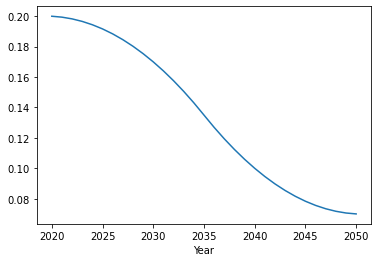

In [9]:
grid_rate = 0.5
cc = 0.2
rates = {2020: 0, 2030: grid_rate*0.3, 2040: grid_rate, 2050: grid_rate*1.3}
e_price_curve = create_learning_curve(2020, 2050, cc, rates, 'polynomial')
e_price_curve.plot()